## Load Dependancies

In [1]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params
from scipy import stats
import statsmodels.api as sm

from sklearn.manifold import MDS
#run repeated measures ANOVA
import pingouin as pg
import pdb

import warnings
warnings.filterwarnings("ignore")



In [2]:
atlas = 'wang'


#load atlast name and roi labels
atlas_info = params.load_atlas_info(atlas)
group_params = params.load_group_params('infant')

sub_info = group_params.sub_list
subs2analyze = sub_info[(sub_info[f'{atlas}_exclude'] != 1) & (sub_info[f'{atlas}_ts'] == 1)]
group = 'infant'

age_bins = [26,33, 38,42,46]
age_groups = ['pre','early','term','post']
group_names = ['Pre-Term','Early-Term','Term','Post-Term']



#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['Occipital']*6 + ['Ventral']*5 + ['Lateral']*6 + ['Dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']

roi_labels = atlas_info.roi_labels

#expand roi labels to include hemis
all_rois = []
all_networks = []


all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




## Dataset characteristics

Text(0, 0.5, 'Count')

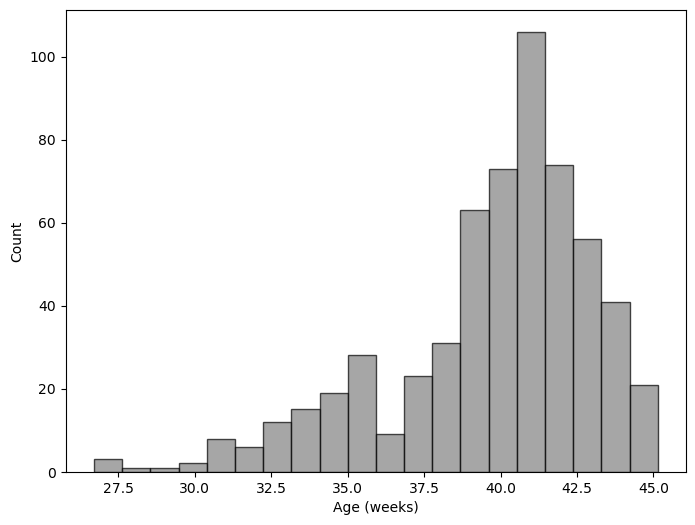

In [3]:
#create histogram of ages
plt.figure(figsize=(8, 6))

plt.hist(subs2analyze['scan_age'], color='gray', edgecolor='black', alpha=0.7, bins=20)
plt.xlabel('Age (weeks)')
plt.ylabel('Count')


## Identify infants with poor signal

Essentially, exclude any subs who are <2 SDs below the mean of the group

In [4]:
#load noise ceiling data
noise_df = pd.read_csv(f'{group_params.out_dir}/derivatives/noise_ceiling/infant_{atlas}_split_half_reliability.csv')

#add age column
noise_df['age'] = (noise_df['scan_age'] - noise_df['birth_age'])*7

#add age group column
noise_df['age_group'] = np.nan

for i in range(len(age_bins)-1):
    noise_df.loc[(noise_df['scan_age'] >= age_bins[i]) & (noise_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['ses'].isin(subs2analyze['ses'])]


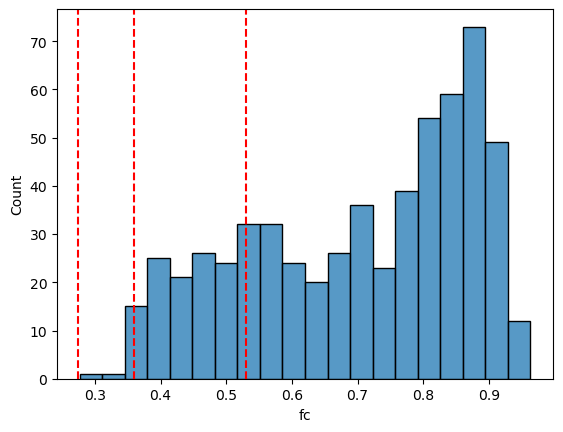

In [5]:
#compute average noise ceiling for each subject
noise_df_mean = noise_df.groupby(['sub', 'ses','age_group']).mean(numeric_only=True).reset_index()

#plot histogram of noise ceiling
plt.figure()
sns.histplot(noise_df_mean['fc'], bins=20)
#add line at SD = 1, 2
#compute SD of noise ceiling
sd = np.std(noise_df_mean['fc'])
mean = np.mean(noise_df_mean['fc'])
plt.axvline(x=mean- sd, color='r', linestyle='--')
plt.axvline(x=mean- (2*sd), color='r', linestyle='--')
plt.axvline(x=mean- (2.5*sd), color='r', linestyle='--')

In [6]:
#print how many subs are below 1, 2, 2.5 SD
print(f'Number of subs below 1 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-sd])}')
print(f'Number of subs below 2 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2*sd)])}')
print(f'Number of subs below 2.5 SD: {len(noise_df_mean[noise_df_mean["fc"] < mean-(2.5*sd)])}')

#print number of subs of each age group below 1, 2, 2.5 SD
for age_group in age_groups:
    print(f'Number of {age_group} subs below 2 SD: {len(noise_df_mean[(noise_df_mean["fc"] < mean-(2*sd)) & (noise_df_mean["age_group"] == age_group)])} out of {len(noise_df_mean[noise_df_mean["age_group"] == age_group])}')
    

Number of subs below 1 SD: 126
Number of subs below 2 SD: 3
Number of subs below 2.5 SD: 0
Number of pre subs below 2 SD: 0 out of 31
Number of early subs below 2 SD: 1 out of 101
Number of term subs below 2 SD: 1 out of 305
Number of post subs below 2 SD: 1 out of 155


In [7]:
#print number of subjects in each group total
for age_group in age_groups:
    print(f'Number of {age_group} subs: {len(noise_df_mean[noise_df_mean["age_group"] == age_group])}')

Number of pre subs: 31
Number of early subs: 101
Number of term subs: 305
Number of post subs: 155


In [8]:
#mark subs with noise ceiling below 2 SD in sub_info sheet
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].astype(str)
sub_info[f'{atlas}_exclude'] = sub_info[f'{atlas}_exclude'].replace('nan', '')

for sub in noise_df_mean[noise_df_mean['fc'] < mean-(2*sd)]['sub']:
    sub_info.loc[sub_info['participant_id'] == sub, f'{atlas}_exclude'] = '1'

In [9]:
#save sub_info sheet
sub_info.to_csv(f'{git_dir}/participants_dhcp.csv', index=False)

### Plot Noise ceilings for each age group

Text(0.5, 0, 'Age Group')

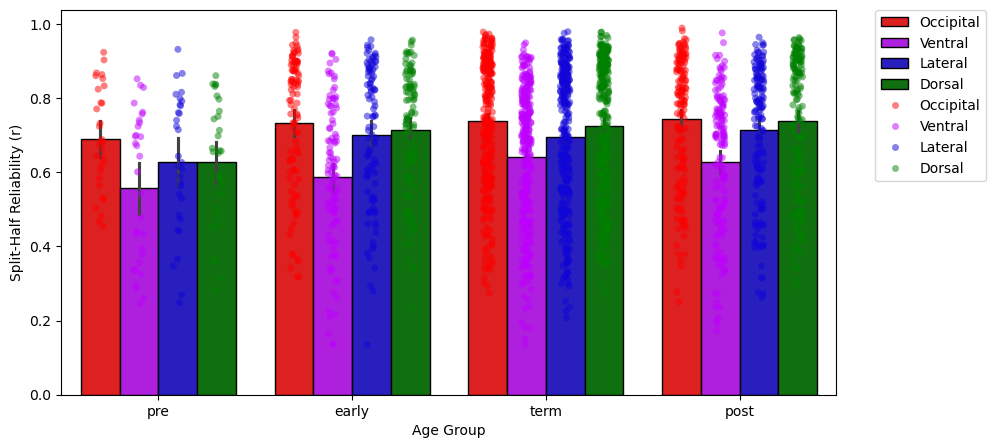

In [12]:


#set network and age_group as categorical
noise_df['network'] = pd.Categorical(noise_df['network'], categories=networks, ordered=True)
noise_df['age_group'] = pd.Categorical(noise_df['age_group'], categories=age_groups, ordered=True)

#only include subs that are in subs2analyze
noise_df = noise_df[noise_df['sub'].isin(subs2analyze['participant_id'])]



#summarize data by network and age group
noise_df = noise_df.groupby(['sub', 'ses', 'network', 'age_group']).mean(numeric_only=True).reset_index()





#plot noise ceiling by network and age group as bar graphs
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='fc', data=noise_df,hue='network', palette=network_colors, edgecolor='k', errorbar=('ci',95))
#add individual data points
sns.stripplot(x='age_group', y='fc', data=noise_df, hue='network', dodge=True, palette=network_colors, edgecolor='k', alpha=0.5)

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#set y axis label 
plt.ylabel('Split-Half Reliability (r)')

#set x axis label
plt.xlabel('Age Group')

(0.3, 1.0)

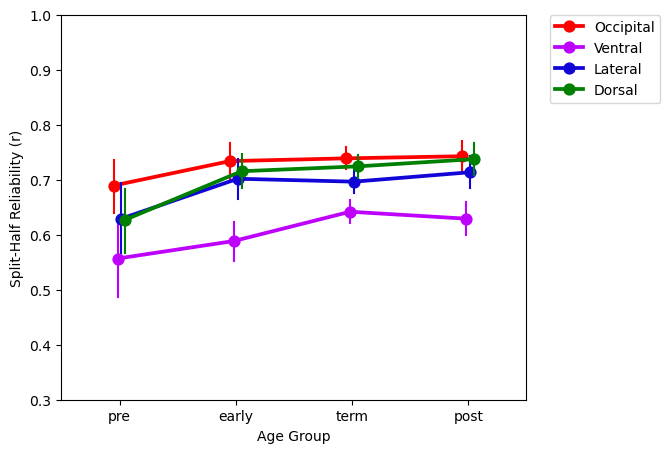

In [11]:
#plot noise ceiling as point_plot
plt.figure(figsize=(6,5))
sns.pointplot(x='age_group', y='fc', data=noise_df, hue='network', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#change y axis label to 'Split-Half Reliability (r)'
plt.ylabel('Split-Half Reliability (r)')
#change x axis label to 'Age Group'
plt.xlabel('Age Group')

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#set y lim to 0.2 to 1
plt.ylim(0.3,1)


## Arealization analyses

In [13]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]





In [14]:
'''load and process adult data'''

adult_fc = pd.read_csv(f'{git_dir}/results/fc_mat/adult_{atlas}_fc_mat.csv', index_col = 0).values
#set diagonal to nan
np.fill_diagonal(adult_fc, np.nan)

#convert to pandas dataframe and melt
adult_df = pd.DataFrame(adult_fc, index = all_rois, columns = all_rois)


#melt so that you have an roi1 and roi1 column
adult_df = adult_df.melt(var_name = 'roi2', value_name = 'fc', ignore_index = False).reset_index().rename(columns = {'index':'roi1'})
adult_df = adult_df.dropna()

#add network labels
adult_df['network1'] = [all_networks[all_rois.index(roi)] for roi in adult_df['roi1']]
adult_df['network2'] = [all_networks[all_rois.index(roi)] for roi in adult_df['roi2']]

#split roi into hemi and roi
adult_df['hemi1'] = adult_df['roi1'].apply(lambda x: x.split('_')[0])
adult_df['roi1'] = adult_df['roi1'].apply(lambda x: x.split('_')[1])

adult_df['hemi2'] = adult_df['roi2'].apply(lambda x: x.split('_')[0])
adult_df['roi2'] = adult_df['roi2'].apply(lambda x: x.split('_')[1])

#add roi_similarity, network_similarity, and hemi_similarity columns
adult_df['roi_similarity'] = ['same' if roi1 == roi2 else 'diff' for roi1, roi2 in zip(adult_df['roi1'], adult_df['roi2'])]
adult_df['network_similarity'] = ['same' if network1 == network2 else 'diff' for network1, network2 in zip(adult_df['network1'], adult_df['network2'])]
adult_df['hemi_similarity'] = ['same' if hemi1 == hemi2 else 'diff' for hemi1, hemi2 in zip(adult_df['hemi1'], adult_df['hemi2'])]

#extract only diff hemispheres
adult_df = adult_df[adult_df['hemi_similarity'] == 'diff']

#groupby roi1, roi2, roi_similarity,  network_similarity, roi_similarity_adj
adult_df = adult_df.groupby(['roi1', 'roi2', 'roi_similarity', 'network_similarity']).mean(numeric_only=True).reset_index()

#create column for  same, adjacent, and distant areas
#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
adult_df['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    adult_df['roi_similarity_adj'] = np.where((adult_df['roi1'] == roi1) & (adult_df['roi2'] == adj1) | (adult_df['roi1'] == roi1) & (adult_df['roi2'] == adj2),
                                                     'Adjacent', adult_df['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    adult_df['roi_similarity_adj'] = np.where(adult_df['roi1'] == adult_df['roi2'], 'Same\nArea', adult_df['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    adult_df['roi_similarity_adj'] = np.where((adult_df['roi1'] != adult_df['roi2']) & (adult_df['roi_similarity_adj'] != 'Adjacent') & (adult_df['roi_similarity_adj'] != 'same'),
                                                     'Distal', adult_df['roi_similarity_adj'])



#### Compute Arealization overall

In [15]:
def create_mat(df,col = 'fc', roi_labels=all_rois):
    #create empty matrix to store infant data
    mat = np.zeros((len(roi_labels), len(roi_labels)))

    #fill in infant matrix with infant data
    for i, roi1 in enumerate(roi_labels):
        for j, roi2 in enumerate(roi_labels):
            mat[i,j] = df[(df['roi1'] == roi1) & (df['roi2'] == roi2)][col].values[0]

    return mat

def plot_fc_matrix(corr_mat, roi_labels, file_name):
    #make diagonal to nans
    corr_mat = np.array(corr_mat)
    print(corr_mat.shape)
    #corr_mat = np.fill_diagonal(corr_mat, np.nan)

    #extract upper triangle
    corr_mat = np.tril(corr_mat)

    #set 0s to nans
    corr_mat[corr_mat == 0] = np.nan


    sns.heatmap(corr_mat, cmap= 'coolwarm', cbar =True, vmin=0, vmax=.8, xticklabels = False, yticklabels = False)
    #make bigger 
    plt.gcf().set_size_inches(12,12)

    #add labels from all_labels
    plt.xticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 90, fontsize = 14)
    plt.yticks(np.arange(0.5, len(roi_labels), 1), roi_labels, rotation = 0, fontsize = 14)

  
    

    #make background black
    ax = plt.gca()

    #make plot square
    ax.set_aspect('equal', 'box')

    #make background white
    ax.set_facecolor('white')

    

    if file_name is not None:
        plt.savefig(f'{git_dir}/figures/{file_name}.png')    

    plt.show()
    plt.pause(.001)



In [16]:
#load adjacency file for rois
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#extract day 1 data
# extract infants that were scanned on day 1 and are either term or post-term
curr_df = sub_df[(sub_df['age'] <= 1) & (sub_df['age_group'] == 'term') | (sub_df['age'] <= 1) & (sub_df['age_group'] == 'post')]


curr_df_median = curr_df.groupby(by=['hemi1', 'roi1', 'hemi2','roi2', 'roi_similarity', 'hemi_similarity']).median(numeric_only=True).reset_index()

#extract hemi_similarity == diff
curr_df_diff = curr_df_median[curr_df_median['hemi_similarity'] == 'diff']

#average by roi1 and roi2, roi_similairty
curr_df_diff = curr_df_diff.groupby(by=['roi1', 'roi2', 'roi_similarity']).mean(numeric_only=True).reset_index()

#extract fc matrix
fc_mat = create_mat(curr_df_diff, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
fc_mat_df = pd.DataFrame(fc_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


(24, 24)


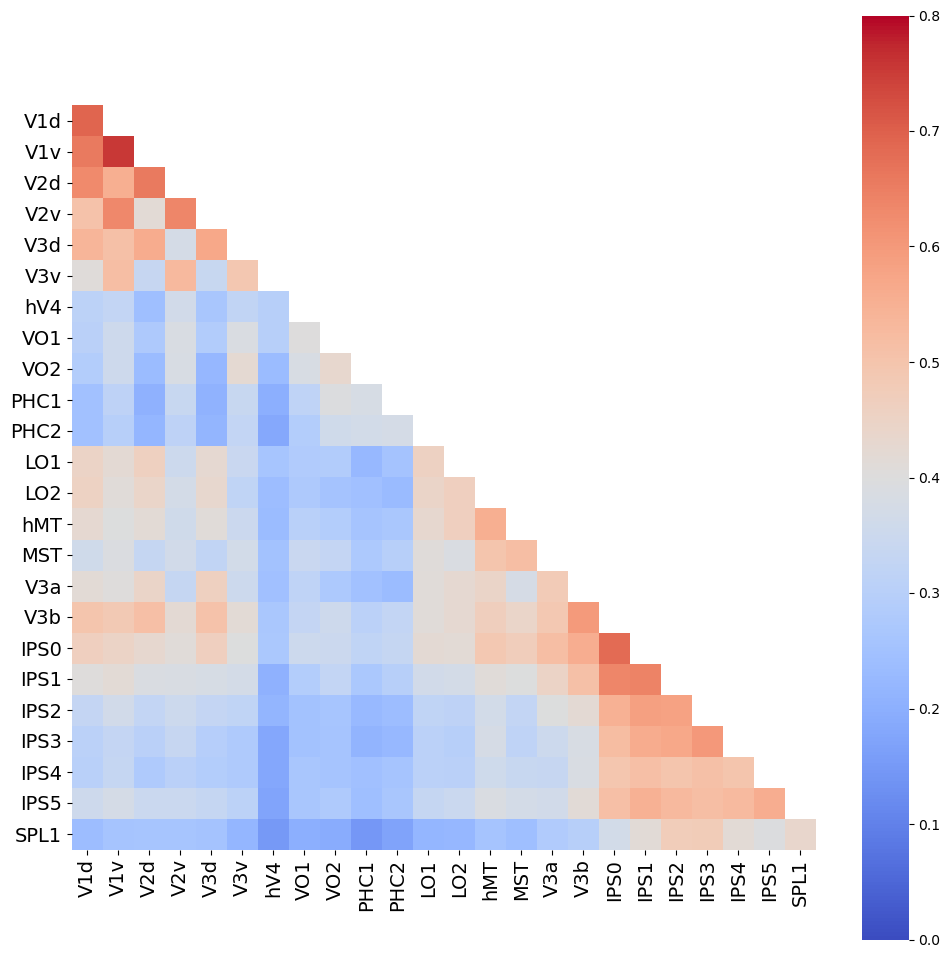

<Figure size 640x480 with 0 Axes>

In [17]:

#create heatmap
plot_fc_matrix(fc_mat_df, adj_rois['label'].to_list(), 'infant_day1_arealization')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/infant_day1_arealization.png')


(24, 24)


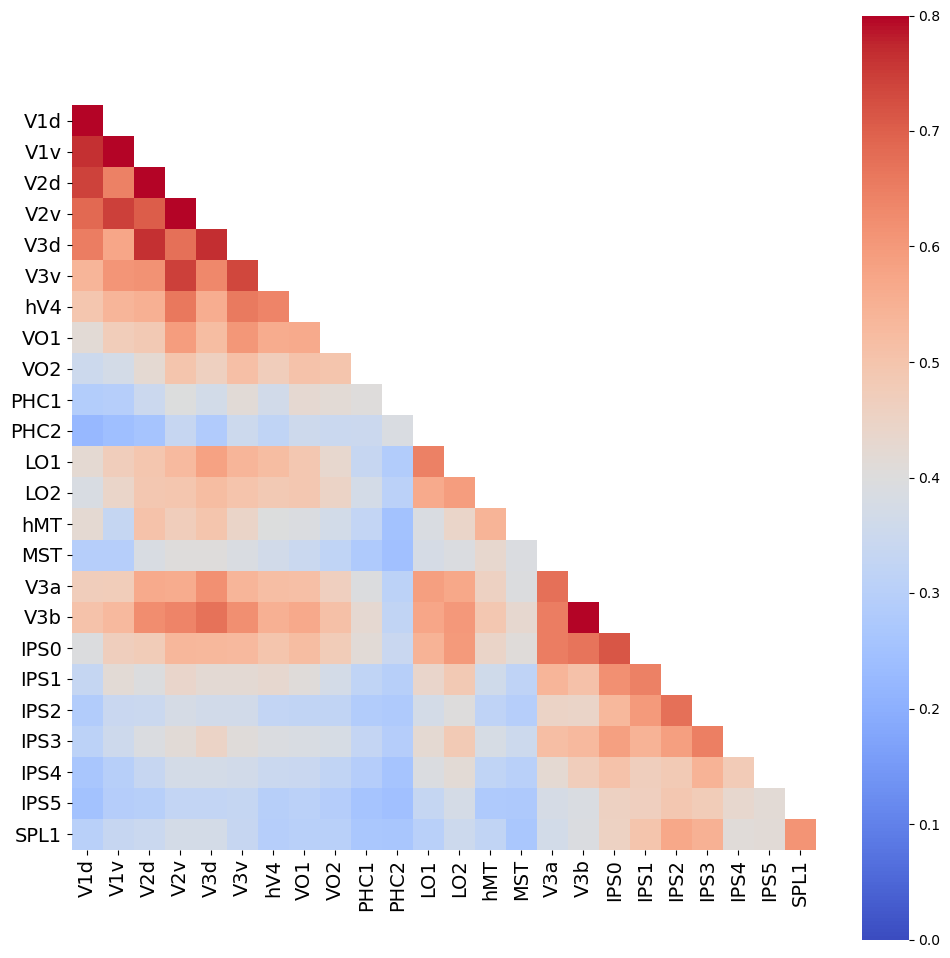

<Figure size 640x480 with 0 Axes>

In [18]:
#create adult heatmap
#extract fc matrix
adult_mat = create_mat(adult_df, col = 'fc', roi_labels = adj_rois['label'].to_list())
#convert to pandas df
adult_mat_df = pd.DataFrame(adult_mat, columns = adj_rois['label'].to_list(), index = adj_rois['label'].to_list())


#create heatmap
plot_fc_matrix(adult_mat_df, adj_rois['label'].to_list(), 'adult_arealization')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/adult_arealization.png')

#### Add distances to data summary

In [19]:
#group by ROIs
df_roi_summary = curr_df.groupby(['sub', 'ses', 'roi1','roi2','hemi_similarity','roi_similarity','network_similarity']).mean(numeric_only=True).reset_index()
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']

#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
df_roi_summary['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj1) | (df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj2),
                                                     'Adjacent', df_roi_summary['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    df_roi_summary['roi_similarity_adj'] = np.where(df_roi_summary['roi1'] == df_roi_summary['roi2'], 'Same\nArea', df_roi_summary['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] != df_roi_summary['roi2']) & (df_roi_summary['roi_similarity_adj'] != 'Adjacent') & (df_roi_summary['roi_similarity_adj'] != 'same'),
                                                     'Distal', df_roi_summary['roi_similarity_adj'])


#### Plot as bars

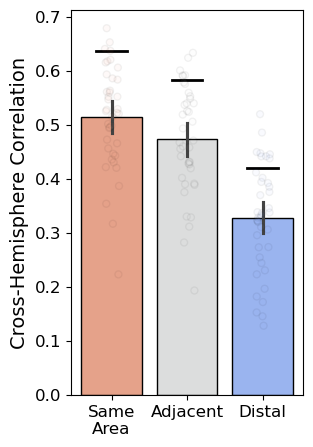

In [20]:
#group by roi_similarity_adj
df_areal_summary = df_roi_summary.groupby(['sub', 'ses', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

adult_df_areal_summary = adult_df.groupby(['roi_similarity_adj']).mean(numeric_only=True).reset_index()


comp_order = ['Same\nArea', 'Adjacent', 'Distal']

#make roi_network_similarity a categorical variable
df_areal_summary['roi_similarity_adj'] = pd.Categorical(df_areal_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
adult_df_areal_summary['roi_similarity_adj'] = pd.Categorical(adult_df_areal_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
#reorder adult_df to match comp_order
adult_df_areal_summary = adult_df_areal_summary.sort_values(by='roi_similarity_adj')

#plot arealization by roi_network_similarity

sns.barplot(x='roi_similarity_adj', y='fc', data=df_areal_summary, palette='coolwarm_r', edgecolor='k', errorbar=('ci',95))

#add individual data points with same colors as bar plot
sns.stripplot(x='roi_similarity_adj', y='fc', data=df_areal_summary, marker = 'o',palette='coolwarm_r', edgecolor='k', linewidth=1,alpha=.05)

#add black line above each bar for adult data
for i, val in enumerate(adult_df_areal_summary['fc']):
    plt.plot([i-0.2, i+0.2], [val, val], color = 'k', linewidth = 2)


#change figure size
plt.gcf().set_size_inches(3,5)

#remove x axis label
plt.xlabel('')
#rename Y-axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize=14)

#set x-axis fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#save figure
plt.savefig(f'{git_dir}/figures/arealization/infant_day1__barplot.png', bbox_inches='tight')

In [21]:


#run repeated measures ANOVA
aovrm = pg.rm_anova(dv='fc', within='roi_similarity_adj', subject='sub', data=df_areal_summary, effsize='np2')

print(aovrm)

#run pairwise comparisons
post_hocs = pg.pairwise_ttests(dv='fc', within='roi_similarity_adj', subject='sub', data=df_areal_summary, padjust='holm', effsize='cohen')
print(post_hocs)

               Source  ddof1  ddof2          F         p-unc       np2  \
0  roi_similarity_adj      2     78  493.51361  5.304225e-45  0.926762   

        eps  
0  0.647311  
             Contrast           A         B  Paired  Parametric          T  \
0  roi_similarity_adj  Same\nArea  Adjacent    True        True  11.884599   
1  roi_similarity_adj  Same\nArea    Distal    True        True  23.841535   
2  roi_similarity_adj    Adjacent    Distal    True        True  22.046196   

    dof alternative         p-unc        p-corr p-adjust       BF10     cohen  
0  39.0   two-sided  1.549454e-14  1.549454e-14     holm   4.52e+11  0.419286  
1  39.0   two-sided  7.329079e-25  2.198724e-24     holm  4.401e+21  1.918133  
2  39.0   two-sided  1.263664e-23  2.527327e-23     holm  2.775e+20  1.454766  


#### Plot roi level analysis

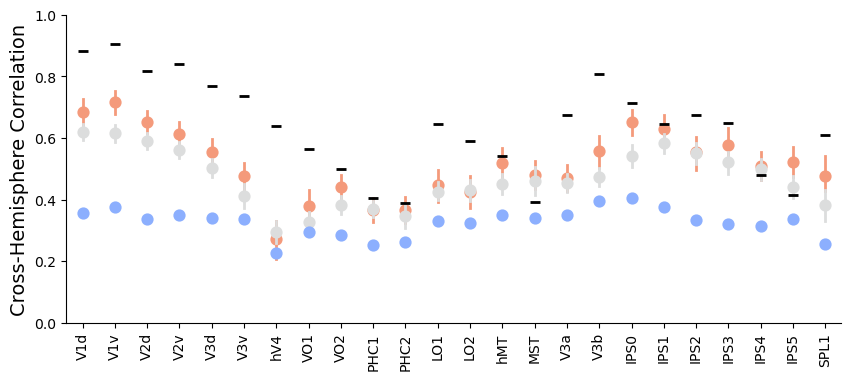

In [22]:
'''
Plot the value of same, adjacent, and distant areas for each ROI
'''

#set order for area distance
df_roi_summary['roi_similarity_adj'] = pd.Categorical(df_roi_summary['roi_similarity_adj'], categories=comp_order, ordered=True)
#set order for rois
df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=adj_rois['label'], ordered=True)

#rename same\nare to same area


#extract same area data from adult
adult_df_same = adult_df[adult_df['roi_similarity_adj'] == 'Same\nArea']
#set categorical variables for adult_roi_summary
adult_df['roi1'] = pd.Categorical(adult_df['roi1'], categories=adj_rois['label'], ordered=True)

#Plot each ROI as a point plot, where x is roi1 and hue is roi_similarity_adj
sns.pointplot(x='roi1', y='fc', data=df_roi_summary, hue='roi_similarity_adj',palette = 'coolwarm_r', ci=95, dodge=False, markers='o', linestyles='', errwidth=2, capsize=0, )

#plot adult data as black lines
sns.pointplot(x='roi1', y='fc', data=adult_df_same, ci=95, dodge=True, markers='_', linestyles='', errwidth=1.5, capsize=0, color='k')

#hide legend
plt.legend().remove()

#change plot size
plt.gcf().set_size_inches(10,4)

#set ylim 
plt.ylim([0, 1])

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Cross-Hemisphere Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save figure
plt.savefig(f'{git_dir}/figures/arealization/infant_day1_roi_pointplot.png', bbox_inches='tight')

#### Compute arealization index as same-adjacent and correlate to adults

In [23]:

#group by roi1 and roi_similarity_adj
df_roi_index = df_roi_summary.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()
#remove rows with 
df_adult_roi = adult_df.groupby(['roi1', 'roi_similarity_adj']).mean(numeric_only=True).reset_index()

#remove rows with distal
df_roi_index = df_roi_index[df_roi_index['roi_similarity_adj'] != 'Distal']
df_adult_roi = df_adult_roi[df_adult_roi['roi_similarity_adj'] != 'Distal']


#pivot table so that each roi is a row and each column is a roi_similarity_adj
df_roi_index = df_roi_index.pivot(index='roi1', columns='roi_similarity_adj', values='fc')
df_adult_roi = df_adult_roi.pivot(index='roi1', columns='roi_similarity_adj', values='fc')
#create new col for each with the difference between same and adjacent
df_roi_index['areal_ratio'] = df_roi_index['Same\nArea'] - df_roi_index['Adjacent']
df_adult_roi['areal_ratio'] = df_adult_roi['Same\nArea'] - df_adult_roi['Adjacent']

#correlate neonate and adult ratios
corr = stats.pearsonr(df_roi_index['areal_ratio'], df_adult_roi['areal_ratio'])

print(corr)





PearsonRResult(statistic=0.5131395152961586, pvalue=0.010337087130912852)


#### compute arealization as a function of areal distance

In [24]:
network_rois = [['V1v', 'V2v','V3v'],['V1d', 'V2d','V3d'],['hV4','VO1','VO2','PHC1','PHC2'], ['LO1','LO2','hMT','MST'], [ 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1']]
networks = ['Occipital_V','Occipital_D', 'Ventral', 'Lateral', 'Dorsal']

#for each roi add number corresponding to its position in the network
df_roi_summary['network1'] = np.nan
df_roi_summary['network2'] = np.nan
df_roi_summary['roi_num1'] = np.nan
df_roi_summary['roi_num2'] = np.nan


for network, rois in zip(networks, network_rois):
    for i, roi in enumerate(rois):
        df_roi_summary['network1'] = np.where(df_roi_summary['roi1'] == roi, network, df_roi_summary['network1'])
        df_roi_summary['network2'] = np.where(df_roi_summary['roi2'] == roi, network, df_roi_summary['network2'])
        df_roi_summary['roi_num1'] = np.where(df_roi_summary['roi1'] == roi, i, df_roi_summary['roi_num1'])
        df_roi_summary['roi_num2'] = np.where(df_roi_summary['roi2'] == roi, i, df_roi_summary['roi_num2'])


#only keep rows where network1 and network2 are the same
df_network_summary = df_roi_summary[df_roi_summary['network1'] == df_roi_summary['network2']]


#add column with num difference between roi1 and roi2
df_network_summary['roi_dist'] = np.abs(df_network_summary['roi_num1'] - df_network_summary['roi_num2'])


#rename occipital_d and occipital_v to occipital
df_network_summary['network1'] = df_network_summary['network1'].replace('Occipital_V', 'Occipital')
df_network_summary['network1'] = df_network_summary['network1'].replace('Occipital_D', 'Occipital')
#same for network2
df_network_summary['network2'] = df_network_summary['network2'].replace('Occipital_V', 'Occipital')
df_network_summary['network2'] = df_network_summary['network2'].replace('Occipital_D', 'Occipital')


#compute arealization distance for adult data
adult_df['network1'] = np.nan
adult_df['network2'] = np.nan

adult_df['roi_num1'] = np.nan
adult_df['roi_num2'] = np.nan

for network, rois in zip(networks, network_rois):
    for i, roi in enumerate(rois):
        adult_df['network1'] = np.where(adult_df['roi1'] == roi, network, adult_df['network1'])
        adult_df['network2'] = np.where(adult_df['roi2'] == roi, network, adult_df['network2'])
        adult_df['roi_num1'] = np.where(adult_df['roi1'] == roi, i, adult_df['roi_num1'])
        adult_df['roi_num2'] = np.where(adult_df['roi2'] == roi, i, adult_df['roi_num2'])

#only keep rows where network1 and network2 are the same
adult_df_network_summary = adult_df[adult_df['network1'] == adult_df['network2']]


#add column with num difference between roi1 and roi2
adult_df_network_summary['roi_dist'] = np.abs(adult_df_network_summary['roi_num1'] - adult_df_network_summary['roi_num2'])


#rename occipital_d and occipital_v to occipital
adult_df_network_summary['network1'] = adult_df_network_summary['network1'].replace('Occipital_V', 'Occipital')
adult_df_network_summary['network1'] = adult_df_network_summary['network1'].replace('Occipital_D', 'Occipital')



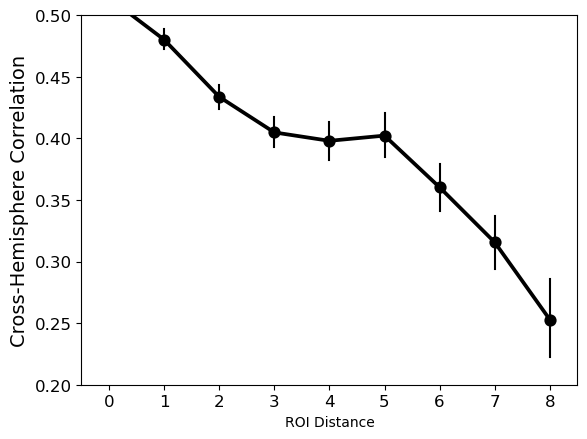

In [25]:
'''Overall arealization only'''

plt.figure()
#plot neonate data
sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

#plot adult data
#sns.pointplot(x='roi_dist', y='fc', data=adult_df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='r')


#set ylim 
plt.ylim([0.2, .5])

#set x axis label
plt.xlabel('ROI Distance')

plt.ylabel('Cross-Hemisphere\nCorrelation')

#make x axis labels integers
plt.xticks(np.arange(0, 9, 1), [str(i) for i in np.arange(0, 9, 1)])

plt.ylabel('Cross-Hemisphere Correlation', fontsize=14)

#set x-axis fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#save figure
plt.savefig(f'{git_dir}/figures/arealization/neonate_areal_distance.png')

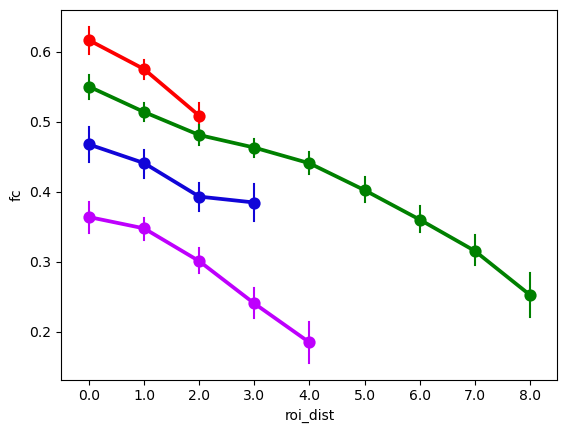

In [26]:
'''
Arealization with just pathways
'''


plt.figure()
#plot arealization by roi_dist as point plot in black
#sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']

#split by network_similarity and loop through each network
for network in ['Occipital','Ventral', 'Lateral','Dorsal']:
    #extract data for network
    curr_df = df_network_summary[df_network_summary['network1'] == network]

    #remove data with occipital_d
    curr_df = curr_df[curr_df['network2'] != 'Occipital_D']
    
    #plot arealization by roi_dist as point plot


    
    sns.pointplot(x='roi_dist', y='fc', data=curr_df, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color=network_colors.pop(0))


## Compute cluster grouping

In [27]:
#load infant data
infant_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')

#add age and age group columns
infant_df['age'] = (infant_df['scan_age'] - infant_df['birth_age'])*7
infant_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    infant_df.loc[(infant_df['scan_age'] >= age_bins[i]) & (infant_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]





#### Conduct analyses on day1 infants

### Plot network and ROI clustering

In [34]:
def create_network_plot(df_network_summary, filename = None):
        
    #group by roi1 and roi2
    df_network_summary = df_network_summary.groupby(['sub', 'network1', 'network_similarity']).mean(numeric_only=True).reset_index()

    #extract only same network_similarity
    #df_roi_summary = df_roi_summary[df_roi_summary['network_similarity'] == 'same']
    network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
    network_order= ['Occipital','Ventral','Lateral','Dorsal']


    '''plot sub data at network level'''

    #set network order
    network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
    comp_order = ['same','diff']
    #comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


    #set network order as categorical and level order
    df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
    #df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


    #create list of 12 gray colors
    network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['green', 'gray']]

    #loop through networks and create subplot for each
    #set subplot size
    fig,ax = plt.subplots(1,4,figsize=(10,3.5),sharey=False)
    for i in range(0,len(network_order)):
        #print(network_order[i])
        curr_data = df_network_summary[(df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'same') | (df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'diff')]
        
        print(curr_data.groupby(['network1','network_similarity'])['dist'].mean())
        
        

        #add dotted line for noise ceiling 
        #noise_df = noise_ceil[(noise_ceil['network1'] == network_order[i]) & (noise_ceil['network_similarity'] == 'same')]
        #ax[i].axhline(y=noise_df['dist'].values[0], color = network_colors[i][0], linestyle = '--')
        
        #plot summary_df
        sns.violinplot(data=curr_data, x= 'network1', y= 'dist', hue='network_similarity',
                    split = True,gap = .2, alpha = .8, inner = 'quart', palette = network_colors[i], ax = ax[i])



        sns.stripplot(data = curr_data,  x= 'network1', y= 'dist', hue = 'network_similarity', 
                    dodge=True,edgecolor = 'black',  linewidth=1,jitter = .2, size = 6,
                        palette = network_colors[i], ax = ax[i],alpha=.5)


        #set y limits
        ax[i].set_ylim([0,4.5])

        #set y interval
        ax[i].set_yticks(np.arange(0,5,1))

        #add y label
        if i == 0:

            ax[i].set_ylabel('Network Distance', fontsize = 14)
            #make axes black
            ax[i].spines['left'].set_color('k')

        
        
        else:
            
            #remove y label
            ax[i].set_ylabel('')
            #remove y ticks
            ax[i].set_yticks([])
            #remove y tick labels
            ax[i].set_yticklabels([])
            #remove y axis line
            ax[i].spines['left'].set_visible(False)

        #remove x ticks and labels
        ax[i].set_xticks([])
        ax[i].set_xticklabels([])
        
        #add network as xlabel for each subplort
        ax[i].set_xlabel(network_order[i], fontsize = 14)
        #add x label
        #plt.xlabel('Network', fontsize = 20)

        #make axes black
        ax[i].spines['bottom'].set_color('k')
        

        #remove top and right axes
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

        #remove legend
        ax[i].get_legend().remove()
        #reverse y axis
        ax[i].invert_yaxis()

        

    plt.subplots_adjust(wspace=.1, hspace=0)

    if filename is not None:
        plt.savefig(f'{git_dir}/figures/cluster/{filename}.png', bbox_inches='tight', dpi = 300)

    plt.show()
    plt.pause(.001)



Plotting network similarity data for both hemis
network1   network_similarity
Occipital  same                  1.226989
           diff                  1.730100
Name: dist, dtype: float64
network1  network_similarity
Ventral   same                  1.249608
          diff                  1.858566
Name: dist, dtype: float64
network1  network_similarity
Lateral   same                  1.227476
          diff                  1.555016
Name: dist, dtype: float64
network1  network_similarity
Dorsal    same                  1.296294
          diff                  1.815608
Name: dist, dtype: float64


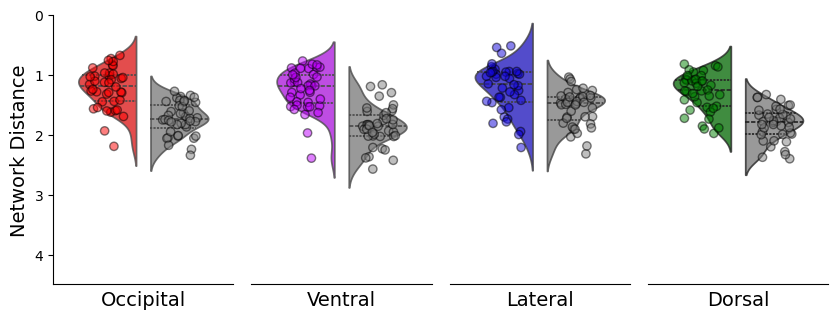

In [ ]:
'''
Plot network similarity data
Both hemis
'''
print('Plotting network similarity data for both hemis')
dist_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/clustering/infant_all_{atlas}_roi_distance.csv')
#adult_dist = pd.read_csv(f'{git_dir}/results/clustering/adult_{atlas}_roi_distance.csv')

#extract day 1 infants
#subtract birth age from scan age to get age
dist_summary['age'] = (dist_summary['scan_age'] - dist_summary['birth_age'])*7

#extract infants that were scanned on day 1 and are either term or post-term
day1_summary = dist_summary[(dist_summary['age'] <= 1) & (dist_summary['age_group'] == 'term') | (dist_summary['age'] <= 1) & (dist_summary['age_group'] == 'post')]

#remove rows where roi_similarity is same
df_network_summary = day1_summary[(day1_summary['roi_similarity'] != 'same') & (day1_summary['hemi_similarity'] != 'same')]
#group by sub, network, network_similarity
df_network_summary = df_network_summary.groupby(['sub', 'network1', 'network_similarity']).mean(numeric_only=True).reset_index()
#adult_network_summary = adult_dist[(adult_dist['roi_similarity'] == 'diff') & (adult_dist['network_similarity'] == 'same')]

#plot network similarity data
create_network_plot(df_network_summary, filename = 'infant_day1_network_distance')



Plotting network similarity data across hemis
network1   network_similarity
Occipital  same                  1.226989
           diff                  1.730100
Name: dist, dtype: float64
network1  network_similarity
Ventral   same                  1.249608
          diff                  1.858566
Name: dist, dtype: float64
network1  network_similarity
Lateral   same                  1.227476
          diff                  1.555016
Name: dist, dtype: float64
network1  network_similarity
Dorsal    same                  1.296294
          diff                  1.815608
Name: dist, dtype: float64


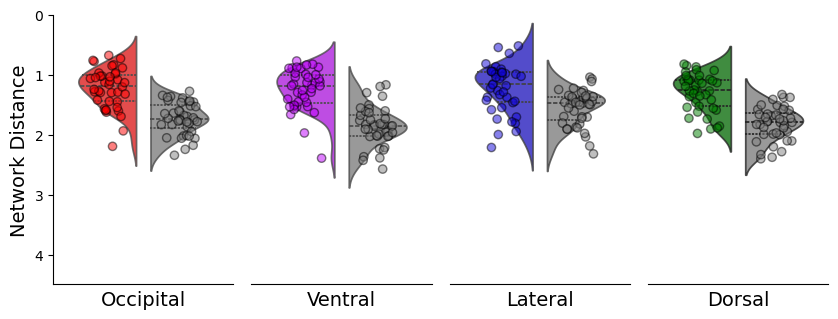

In [37]:
'''
Plot network distance data
Across hemis
'''
print('Plotting network similarity data across hemis')
#dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#remove rows where roi_similarity is same
df_network_summary = day1_summary[(day1_summary['roi_similarity'] == 'diff') & (day1_summary['hemi_similarity'] == 'diff')]
df_network_summary = df_network_summary.groupby(['sub', 'network1', 'network_similarity']).mean(numeric_only=True).reset_index()

#plot network similarity data
create_network_plot(df_network_summary, filename = 'infant_day1_network_distance_across_hemis')



In [38]:
'''Conduct analysis'''
#load infant dist summary
dist_df = day1_summary

#Exclude same rois with same hemi and same roi
dist_df = dist_df[(dist_df['roi_similarity'] != 'same') & (dist_df['hemi_similarity'] != 'same')]

#group by sub, network1, network_similarity
dist_summary = dist_df.groupby(['sub','network1','network_similarity']).mean(numeric_only=True).reset_index()

#run repeated measures ANOVA with network1 and network_similarity as the within subject
aovrm = pg.rm_anova(dv='dist', within=['network1', 'network_similarity'], subject='sub', data=dist_summary, effsize='np2')

print(aovrm)

#run pairwise comparisons
post_hocs = pg.pairwise_ttests(dv='dist', within=['network1', 'network_similarity'], subject='sub', data=dist_summary, padjust='holm', effsize='cohen')
print(post_hocs)


                          Source         SS  ddof1  ddof2         MS  \
0                       network1   1.459358      3    117   0.486453   
1             network_similarity  19.186915      1     39  19.186915   
2  network1 * network_similarity   0.831507      3    117   0.277169   

            F         p-unc     p-GG-corr       np2       eps  
0    9.354074  1.363086e-05  4.907379e-05  0.193450  0.847953  
1  300.660591  6.296856e-20  6.296856e-20  0.885179  1.000000  
2    6.907130  2.535824e-04  3.739617e-04  0.150459  0.932151  
                         Contrast   network1          A          B Paired  \
0                        network1          -     Dorsal    Lateral   True   
1                        network1          -     Dorsal  Occipital   True   
2                        network1          -     Dorsal    Ventral   True   
3                        network1          -    Lateral  Occipital   True   
4                        network1          -    Lateral    Ventral   T

In [39]:
def create_roi_plot(df_roi_summary, filename=None):
        
    #group by roi1 and roi2
    df_roi_summary = df_roi_summary.groupby(['network1', 'roi1', 'network2', 'roi2', 'network_similarity']).mean(numeric_only=True).reset_index()

    #extract only same network_similarity
    #df_roi_summary = df_roi_summary[df_roi_summary['network_similarity'] == 'same']
    network_colors = ['#fd0000','#be00fd', '#1105d8','green']
    network_order= ['Occipital','Ventral','Lateral','Dorsal']


    #set network order as categorical and level order
    df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=roi_labels['label'], ordered=True)
    df_roi_summary['network2'] = pd.Categorical(df_roi_summary['network2'], categories=network_order, ordered=True)

    #fig,ax = plt.subplots(1,1,figsize=(10,3.5),sharey=False)
    plt.figure(figsize=(10, 3.5))

    sns.stripplot(data = df_roi_summary, x = 'roi1', y = 'dist', hue = 'network2', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)

    #set ylim
    #plt.ylim([.8, 3])

    #set y interval
    plt.yticks(np.arange(0.5,3.5,.5))

    #create scatter plot of noise ceiling
    #sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

    #remove legend
    plt.legend([],[], frameon=False)

    #change plot size
    plt.gcf().set_size_inches(10,3.5)

    #angle x axis labels
    plt.xticks(rotation=90)

    #invert y axis
    plt.gca().invert_yaxis()

    #put x axis on top
    #plt.gca().xaxis.tick_top()

    #remove top and right spines
    sns.despine()

    #add y axis label
    plt.ylabel('Area Distance', fontsize = 14)

    #remove X axis label
    plt.xlabel('')
    

    if filename is not None:
        plt.savefig(f'{git_dir}/figures/cluster/{filename}.png', bbox_inches='tight', dpi = 300)

    plt.show()
    plt.pause(.001)

    

Plotting roi similarity data for both hemis


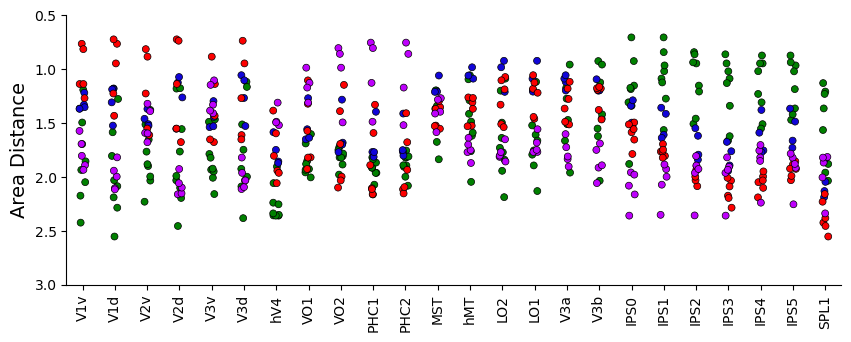

Plotting roi similarity data across hemis


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/DataDrive3/vlad/git_repos/dhcp/results/clustering/infant_day1_wang_roi_distance.csv'

In [ ]:
'''
Plot data at roi level

This include both hemis
'''
print('Plotting roi similarity data for both hemis')
dist_summary = day1_summary

#remove rows where roi_similarity is same
df_roi_summary = dist_summary[dist_summary['roi_similarity'] == 'diff']

#plot roi similarity data
create_roi_plot(df_roi_summary, filename = 'infant_day1_roi_distance')

''' 
PLot data from only cross- hemis

print('Plotting roi similarity data across hemis')
dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#remove rows where roi_similarity is same
df_roi_summary = dist_summary[(dist_summary['roi_similarity'] == 'diff') & (dist_summary['hemi_similarity'] == 'diff')]

#plot roi similarity data
create_roi_plot(df_roi_summary, filename = 'infant_day1_roi_distance_cross_hemis')
'''



### Plot grouping by agegroup

In [53]:
dist_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/clustering/infant_all_{atlas}_roi_distance.csv')

#group by sub, network1, network_similarity, age_group
dist_summary = dist_summary.groupby(['sub','network1', 'network_similarity', 'age_group']).mean(numeric_only=True).reset_index()

#pivot so that network_similarity is columns
dist_summary_wide = dist_summary.pivot(index=['sub','age_group','network1'], columns='network_similarity', values='dist').reset_index()

#create new column for difference between same and diff
dist_summary_wide['similarity_diff'] = dist_summary_wide['diff'] - dist_summary_wide['same']




<Axes: xlabel='age_group', ylabel='dist'>

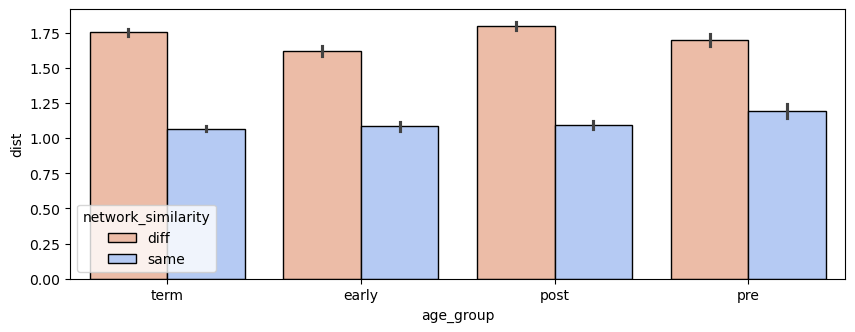

In [51]:
#plot grouping as bargraphs 
plt.figure(figsize=(10,3.5))
#plot data as barplot
sns.barplot(x='age_group', y='dist', hue='network_similarity', data=dist_summary, palette = 'coolwarm_r', edgecolor='k', errorbar=('ci',95))

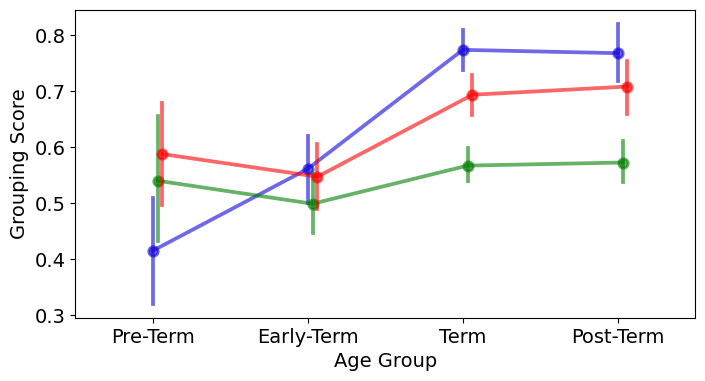

In [54]:
#line plot as a function of age_group and network1
network_colors = ['#fd0000', '#be00fd', '#1105d8', 'green']
#make age_group categorical
dist_summary_wide['age_group'] = pd.Categorical(dist_summary_wide['age_group'], categories=age_groups, ordered=True)
#make network1 categorical
dist_summary_wide['network1'] = pd.Categorical(dist_summary_wide['network1'], categories=networks, ordered=True)

#rename age_groups
dist_summary_wide['age_group'] = dist_summary_wide['age_group'].replace({'pre':'Pre-Term', 'early':'Early-Term', 'term':'Term', 'post':'Post-Term'})

plt.figure(figsize=(8,4))
sns.pointplot(x='age_group', y='similarity_diff', data=dist_summary_wide, hue='network1', palette = network_colors, ci=95, dodge=True, alpha = .6)


#set x axis fontsize
plt.xticks(fontsize = 14)
#change y axis fontsize
plt.yticks(fontsize = 14)

#change x axist title
plt.xlabel('Age Group', fontsize = 14)

#change y axis title
plt.ylabel('Grouping Score', fontsize = 14)

#remove legend
plt.legend([],[], frameon=False)

### Test hierarchy

In [30]:
'''
Test hierachy of areas (averaging across hemis)

for each roi determine the next closest roi in the network
'''


network_rois = [['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2',''], ['V1d', 'V2d','V3d', 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1',''], ['V1d', 'V2d','V3d' ,'LO1','LO2','hMT','MST','']]
networks = ['Ventral', 'Dorsal', 'Lateral']

#load infant dist data
dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#average by hemi sub and roi
#remove rows where roi_similarity is same
df_roi_summary = dist_summary[dist_summary['roi_similarity'] == 'diff']

#group by roi1 and roi2
df_roi_summary = df_roi_summary.groupby(['network1', 'roi1', 'network2', 'roi2', 'network_similarity']).mean(numeric_only=True).reset_index()

hierarchy_summary = pd.DataFrame(columns = ['network', 'curr_roi1', 'anat_roi2','actual_roi2', 'anat_rank','actual_rank'])


for network, rois in zip(networks, network_rois):

    #extract only rows where roi1 and roi2 is in rois
    network_df = df_roi_summary[df_roi_summary['roi1'].isin(rois)]
    network_df = network_df[network_df['roi2'].isin(rois)]
    
    roi_index = []
    tested_rois = []
    for n, roi in enumerate(rois):
        if n == 0:
            curr_roi = roi
        
        curr_df = network_df[network_df['roi1'] == curr_roi]

        tested_rois.append(curr_roi)


        if n !=0:
            #remove tested rois from curr_df
            curr_df = curr_df[~curr_df['roi2'].isin(tested_rois)]
        
        #skip if last roi
        if n == len(rois)-2:
            print('done')
            break
       
        #find the next closest roi
        next_roi = curr_df[curr_df['dist'] == np.min(curr_df['dist'])]['roi2'].values[0]

        #this is the roi that should be next
        anat_roi = rois[rois.index(curr_roi)+1]
        anat_rank = rois.index(anat_roi)

        actual_roi = next_roi
        actual_rank = rois.index(next_roi)

        #add to hierarchy_summary
        hierarchy_summary = pd.concat([hierarchy_summary, pd.DataFrame([[network, curr_roi, anat_roi, actual_roi, anat_rank, actual_rank]], columns = ['network', 'curr_roi1', 'anat_roi2','actual_roi2', 'anat_rank','actual_rank'])])

        #add index of next_roi to roi_index
        roi_index.append(rois.index(next_roi))

        #set curr_roi to next_roi
        curr_roi = next_roi

        #if n == 3:
        #    break
    
            



done
done
done


In [31]:
networks = ['Ventral', 'Dorsal', 'Lateral']
#compute rank order correlation between true and projected rank
corr = stats.spearmanr(hierarchy_summary['anat_rank'], hierarchy_summary['actual_rank'])
print(corr)
#loop through each network and print the correlation between true and projected rank
for network in networks:
    curr_df = hierarchy_summary[hierarchy_summary['network'] == network]
    #remove rows with V1v,V2v, V1d, V2d
    curr_df = curr_df[~curr_df['curr_roi1'].isin(['V1v', 'V2v', 'V1d', 'V2d'])]

    corr = stats.pearsonr(curr_df['anat_rank'], curr_df['actual_rank'])
    print(network, corr)
    

SignificanceResult(statistic=0.8610989010989013, pvalue=6.635234897467372e-08)
Ventral PearsonRResult(statistic=0.08219949365267867, pvalue=0.8954583338276433)
Dorsal PearsonRResult(statistic=0.9999999999999999, pvalue=0.0)
Lateral PearsonRResult(statistic=-0.37796447300922736, pvalue=0.6220355269907727)


In [37]:
np.corrcoef(curr_df['anat_rank'].values, curr_df['actual_rank'].values)

AttributeError: 'float' object has no attribute 'shape'

In [11]:
'''
Test hierachy of areas (averaging across hemis)
'''


network_rois = [['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2',''], ['V1d', 'V2d','V3d', 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1',''], ['V1d', 'V2d','V3d' ,'LO1','LO2','hMT','MST','']]
networks = ['Ventral', 'Dorsal', 'Lateral']

#load infant dist data
dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#average by hemi sub and roi
#remove rows where roi_similarity is same
df_roi_summary = dist_summary[dist_summary['roi_similarity'] == 'diff']

#group by roi1 and roi2
df_roi_summary = df_roi_summary.groupby(['network1', 'roi1', 'network2', 'roi2', 'network_similarity']).mean(numeric_only=True).reset_index()

hierarchy_summary = pd.DataFrame(columns = ['network', 'roi1', 'true_roi2','projected_roi2', 'true_rank','projected_rank'])


for network, rois in zip(networks, network_rois):

    #extract only rows where roi1 and roi2 is in rois
    network_df = df_roi_summary[df_roi_summary['roi1'].isin(rois)]
    network_df = network_df[network_df['roi2'].isin(rois)]
    
    roi_index = []
    for n, roi in enumerate(rois):
        curr_df = network_df[network_df['roi1'] == roi]

        if n !=0:
            #remove rows with the previously tested rois
            curr_df = curr_df[curr_df['roi2'] != rois[n-1]]

        if n == len(rois)-1:
            continue
       
        #find the next closest roi
        next_roi = curr_df[curr_df['dist'] == np.min(curr_df['dist'])]['roi2'].values[0]


        #add to hierarchy_summary
        hierarchy_summary = pd.concat([hierarchy_summary, pd.DataFrame([[network, roi, rois[n+1], next_roi, n+1, rois.index(next_roi)]], columns = ['network', 'roi1', 'true_roi2','projected_roi2', 'true_rank','projected_rank'])])

        #add index of next_roi to roi_index
        roi_index.append(rois.index(next_roi))
        



In [46]:
rois[rois.index('PHC1')+1]

'PHC2'

In [71]:
'''
Test hierachy of areas within hemi
'''

network_rois = [['V1v', 'V2v','V3v'],['V1d', 'V2d','V3d'],['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2'], ['V1d', 'V2d','V3d','V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1'], ['V1d', 'V2d','V3d','LO1','LO2','hMT','MST']]
networks = ['Occipital_v', 'Occipital_d', 'Ventral', 'Dorsal', 'Lateral']

#load infant dist data
dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#average by hemi sub and roi
#remove rows where roi_similarity is same
df_roi_summary = dist_summary[(dist_summary['roi_similarity'] == 'diff') & (dist_summary['hemi_similarity'] == 'same')]

#group by roi1 and roi2
df_roi_summary = df_roi_summary.groupby(['hemi1','network1', 'roi1', 'network2', 'roi2', 'hemi_similarity','network_similarity']).mean(numeric_only=True).reset_index()

hierarchy_summary = pd.DataFrame(columns = ['hemi','network', 'roi1', 'true_roi2','projected_roi2', 'true_rank','projected_rank'])


for network, rois in zip(networks, network_rois):

    #extract only rows where roi1 and roi2 is in rois
    network_df = df_roi_summary[df_roi_summary['roi1'].isin(rois)]
    network_df = network_df[network_df['roi2'].isin(rois)]
    
    for hemi in ['lh', 'rh']:
        for n, roi in enumerate(rois):
            
            if n == len(rois)-1:
                continue
            

            curr_df = network_df[(network_df['roi1'] == roi) & (network_df['hemi1'] == hemi)]
            if n !=0:
                #remove rows with the previously tested rois
                curr_df = curr_df[curr_df['roi2'] != rois[n-1]]

            
        
            #find the next closest roi
            next_roi = curr_df[curr_df['dist'] == np.min(curr_df['dist'])]['roi2'].values[0]

            print([hemi, network, roi, rois[n+1], next_roi, n+1, rois.index(next_roi)])
            #add to hierarchy_summary
            hierarchy_summary = pd.concat([hierarchy_summary, pd.DataFrame([[hemi, network, roi, rois[n+1], next_roi, n+1, rois.index(next_roi)]], columns = ['hemi','network', 'roi1', 'true_roi2','projected_roi2', 'true_rank','projected_rank'])])



#rename occipital_d and occipital_v to occipital
hierarchy_summary['network'] = hierarchy_summary['network'].replace('Occipital_v', 'Occipital')
hierarchy_summary['network'] = hierarchy_summary['network'].replace('Occipital_d', 'Occipital')

#if network is ventral, remove rows if roi1 and roi2 are in occipital_v
#hierarchy_summary = hierarchy_summary[~((hierarchy_summary['network'] == 'Ventral') & (hierarchy_summary['roi1'].isin(network_rois[0])) & (hierarchy_summary['true_roi2'].isin(network_rois[0])))]

#if network is dorsal, remove rows if roi1 and roi2 are in occipital_d
#hierarchy_summary = hierarchy_summary[~((hierarchy_summary['network'] == 'Dorsal') & (hierarchy_summary['roi1'].isin(network_rois[1])) & (hierarchy_summary['true_roi2'].isin(network_rois[1])))]


#if network is lateral, remove rows if roi1 and roi2 are in occipital_d
#hierarchy_summary = hierarchy_summary[~((hierarchy_summary['network'] == 'Lateral') & (hierarchy_summary['roi1'].isin(network_rois[1])) & (hierarchy_summary['true_roi2'].isin(network_rois[1])))]


['lh', 'Occipital_v', 'V1v', 'V2v', 'V2v', 1, 1]
['lh', 'Occipital_v', 'V2v', 'V3v', 'V3v', 2, 2]
['rh', 'Occipital_v', 'V1v', 'V2v', 'V2v', 1, 1]
['rh', 'Occipital_v', 'V2v', 'V3v', 'V3v', 2, 2]
['lh', 'Occipital_d', 'V1d', 'V2d', 'V2d', 1, 1]
['lh', 'Occipital_d', 'V2d', 'V3d', 'V3d', 2, 2]
['rh', 'Occipital_d', 'V1d', 'V2d', 'V2d', 1, 1]
['rh', 'Occipital_d', 'V2d', 'V3d', 'V3d', 2, 2]
['lh', 'Ventral', 'V1v', 'V2v', 'V2v', 1, 1]
['lh', 'Ventral', 'V2v', 'V3v', 'V3v', 2, 2]
['lh', 'Ventral', 'V3v', 'hV4', 'V1v', 3, 0]
['lh', 'Ventral', 'hV4', 'VO1', 'VO1', 4, 4]
['lh', 'Ventral', 'VO1', 'VO2', 'VO2', 5, 5]
['lh', 'Ventral', 'VO2', 'PHC1', 'PHC1', 6, 6]
['lh', 'Ventral', 'PHC1', 'PHC2', 'PHC2', 7, 7]
['rh', 'Ventral', 'V1v', 'V2v', 'V2v', 1, 1]
['rh', 'Ventral', 'V2v', 'V3v', 'V3v', 2, 2]
['rh', 'Ventral', 'V3v', 'hV4', 'VO2', 3, 5]
['rh', 'Ventral', 'hV4', 'VO1', 'VO1', 4, 4]
['rh', 'Ventral', 'VO1', 'VO2', 'VO2', 5, 5]
['rh', 'Ventral', 'VO2', 'PHC1', 'PHC1', 6, 6]
['rh', 'Ventral'

In [12]:
'''
Test hierachy of areas between hemi
'''


network_rois = [['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2', ''], ['V1d', 'V2d','V3d', 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1', ''], ['V1d', 'V2d','V3d' ,'LO1','LO2','hMT','MST', '']]
networks = ['Ventral', 'Dorsal', 'Lateral']

#load infant dist data
dist_summary = pd.read_csv(f'{git_dir}/results/clustering/infant_day1_{atlas}_roi_distance.csv')

#average by hemi sub and roi
#remove rows where roi_similarity is same
df_roi_summary = dist_summary[(dist_summary['roi_similarity'] == 'diff') & (dist_summary['hemi_similarity'] == 'diff')]

#group by roi1 and roi2
df_roi_summary = df_roi_summary.groupby(['hemi1','network1', 'roi1', 'network2', 'roi2', 'hemi_similarity','network_similarity']).mean(numeric_only=True).reset_index()

hierarchy_summary = pd.DataFrame(columns = ['hemi','network', 'roi1', 'true_roi2','projected_roi2', 'true_rank','projected_rank'])


for network, rois in zip(networks, network_rois):

    #extract only rows where roi1 and roi2 is in rois
    network_df = df_roi_summary[df_roi_summary['roi1'].isin(rois)]
    network_df = network_df[network_df['roi2'].isin(rois)]
    
    for hemi in ['lh', 'rh']:
        for n, roi in enumerate(rois):
            
            if n == len(rois)-1:
                continue
            

            curr_df = network_df[(network_df['roi1'] == roi) & (network_df['hemi1'] == hemi)]
            if n !=0:
                #remove rows with the previously tested rois
                curr_df = curr_df[curr_df['roi2'] != rois[n-1]]

            
        
            #find the next closest roi
            next_roi = curr_df[curr_df['dist'] == np.min(curr_df['dist'])]['roi2'].values[0]

            print([hemi, network, roi, rois[n+1], next_roi, n+1, rois.index(next_roi)])
            #add to hierarchy_summary
            hierarchy_summary = pd.concat([hierarchy_summary, pd.DataFrame([[hemi, network, roi, rois[n+1], next_roi, n+1, rois.index(next_roi)]], columns = ['hemi','network', 'roi1', 'true_roi2','projected_roi2', 'true_rank','projected_rank'])])



['lh', 'Ventral', 'V1v', 'V2v', 'V2v', 1, 1]
['lh', 'Ventral', 'V2v', 'V3v', 'V3v', 2, 2]
['lh', 'Ventral', 'V3v', 'hV4', 'V1v', 3, 0]
['lh', 'Ventral', 'hV4', 'VO1', 'VO1', 4, 4]
['lh', 'Ventral', 'VO1', 'VO2', 'VO2', 5, 5]
['lh', 'Ventral', 'VO2', 'PHC1', 'PHC2', 6, 7]
['lh', 'Ventral', 'PHC1', 'PHC2', 'PHC2', 7, 7]
['lh', 'Ventral', 'PHC2', '', 'VO2', 8, 5]
['rh', 'Ventral', 'V1v', 'V2v', 'V2v', 1, 1]
['rh', 'Ventral', 'V2v', 'V3v', 'V3v', 2, 2]
['rh', 'Ventral', 'V3v', 'hV4', 'VO1', 3, 4]
['rh', 'Ventral', 'hV4', 'VO1', 'VO1', 4, 4]
['rh', 'Ventral', 'VO1', 'VO2', 'VO2', 5, 5]
['rh', 'Ventral', 'VO2', 'PHC1', 'PHC1', 6, 6]
['rh', 'Ventral', 'PHC1', 'PHC2', 'PHC2', 7, 7]
['rh', 'Ventral', 'PHC2', '', 'VO2', 8, 5]
['lh', 'Dorsal', 'V1d', 'V2d', 'V2d', 1, 1]
['lh', 'Dorsal', 'V2d', 'V3d', 'V3d', 2, 2]
['lh', 'Dorsal', 'V3d', 'V3a', 'V1d', 3, 0]
['lh', 'Dorsal', 'V3a', 'V3b', 'V2d', 4, 1]
['lh', 'Dorsal', 'V3b', 'IPS0', 'V2d', 5, 1]
['lh', 'Dorsal', 'IPS0', 'IPS1', 'IPS1', 6, 6]
['lh',

SignificanceResult(statistic=0.8530791622320499, pvalue=1.375203571056177e-14)


In [54]:
#loop through each network and print the correlation between true and projected rank
for network in networks:
    curr_df = hierarchy_summary[hierarchy_summary['network'] == network]
    corr = stats.spearmanr(curr_df['true_rank'], curr_df['projected_rank'])
    print(network, corr)

Ventral SignificanceResult(statistic=0.8789326040843648, pvalue=3.485231334746167e-05)
Dorsal SignificanceResult(statistic=0.8735472550237366, pvalue=1.1084002983555794e-07)
Lateral SignificanceResult(statistic=0.504524979109513, pvalue=0.09437359840343584)


In [23]:
#average by hemi sub and roi
df_roi = sub_df.groupby(['sub', 'ses',  'roi1', 'roi2']).mean(numeric_only=True).reset_index()


#pivot so that sub and roi1 are indices and roi2 is columns
df_roi = df_roi.pivot_table(index = ['sub', 'ses', 'roi1'], columns = 'roi2', values = 'fc').reset_index()

#for each subject compute the distance between all rois
roi_dist = []
for sub in df_roi['sub'].unique():
    curr_df = df_roi[df_roi['sub'] == sub]
    #compute euclidean distance between all rois in a pairwise fashion
    dist = []
    for i in range(len(curr_df)):
        for j in range(len(curr_df)):
            dist.append(np.linalg.norm(curr_df.iloc[i,3:].values - curr_df.iloc[j,3:].values))
    

## Look at all effects as a function of age

### Arealization

In [61]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')
adj_rois = pd.read_csv(f'{git_dir}/analysis/Wang_adjacent_labels.csv')

#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]


#group by ROIs
df_roi_summary = sub_df.groupby(['sub', 'ses','network1','network2', 'roi1','roi2','hemi_similarity','roi_similarity','network_similarity', 'age_group']).mean(numeric_only=True).reset_index()
df_roi_summary = df_roi_summary[df_roi_summary['hemi_similarity'] == 'diff']


#add adjacency category to roi_similarity
#loop over roi1 and if roi2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
df_roi_summary['roi_similarity_adj'] = np.nan


#label same, adjacent, and distant areas
for roi1,adj1, adj2 in zip(adj_rois['label'], adj_rois['adjacent1'], adj_rois['adjacent2']):
    #if ro2 is in adjacent1 or adjacent2, set roi_similarity to adjacent
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj1) | (df_roi_summary['roi1'] == roi1) & (df_roi_summary['roi2'] == adj2),
                                                     'Adjacent', df_roi_summary['roi_similarity_adj'])
    
    #if roi1 == roi2, set roi_similarity to same
    df_roi_summary['roi_similarity_adj'] = np.where(df_roi_summary['roi1'] == df_roi_summary['roi2'], 'Same\nArea', df_roi_summary['roi_similarity_adj'])

    #if roi1 != roi2 and roi_similarity_adj is nan, set roi_similarity to distant
    df_roi_summary['roi_similarity_adj'] = np.where((df_roi_summary['roi1'] != df_roi_summary['roi2']) & (df_roi_summary['roi_similarity_adj'] != 'Adjacent') & (df_roi_summary['roi_similarity_adj'] != 'same'),
                                                     'Distal', df_roi_summary['roi_similarity_adj'])



In [62]:
#create summary by roi_similarity_adj
df_network_summary = df_roi_summary.groupby(['sub','ses','age_group','network1','roi_similarity_adj']).mean(numeric_only=True).reset_index()

#pivot so that sub and network are indices and roi_similarity_adj is columns
df_network_summary = df_network_summary.pivot_table(index = ['sub', 'ses', 'age_group', 'network1'], columns = 'roi_similarity_adj', values = 'fc').reset_index()

#make new column with arealization index
df_network_summary['adjacent_arealization'] = df_network_summary['Same\nArea'] - df_network_summary['Adjacent']
df_network_summary['distant_arealization'] = df_network_summary['Same\nArea'] - df_network_summary['Distal']

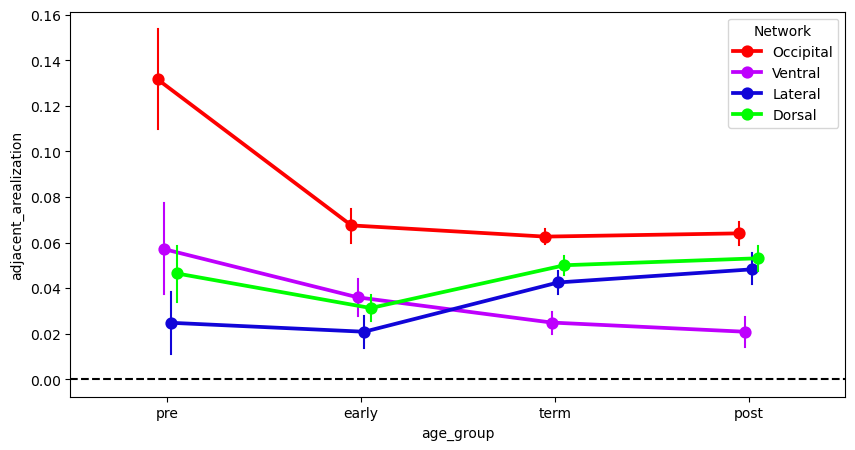

In [63]:
#make age_group categorical
df_network_summary['age_group'] = pd.Categorical(df_network_summary['age_group'], categories=age_groups, ordered=True)
#network categorical
df_network_summary['network1'] = pd.Categorical(df_network_summary['network1'], categories=networks, ordered=True)

#point plot of arealization index
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='adjacent_arealization', data=df_network_summary, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#dotted line at 0
plt.axhline(y=0, color = 'k', linestyle = '--')

#put legend outside of plot
plt.legend(bbox_to_anchor=(6.04, 1), loc="upper left")
#Change legend title to network
plt.legend(title='Network')

#plt.ylim(-.1,.25)

#### plot arealization as function of distance


In [ ]:
network_rois = [['V1v', 'V2v','V3v'],['V1d', 'V2d','V3d'],['hV4','VO1','VO2','PHC1','PHC2'], ['LO1','LO2','hMT','MST'], [ 'V3a','V3b','IPS0','IPS1','IPS2','IPS3', 'IPS4', 'IPS5', 'SPL1']]
networks = ['Occipital_V','Occipital_D', 'Ventral', 'Lateral', 'Dorsal']

#for each roi add number corresponding to its position in the network
df_roi_summary['network1'] = np.nan
df_roi_summary['network2'] = np.nan
df_roi_summary['roi_num1'] = np.nan
df_roi_summary['roi_num2'] = np.nan


for network, rois in zip(networks, network_rois):
    for i, roi in enumerate(rois):
        df_roi_summary['network1'] = np.where(df_roi_summary['roi1'] == roi, network, df_roi_summary['network1'])
        df_roi_summary['network2'] = np.where(df_roi_summary['roi2'] == roi, network, df_roi_summary['network2'])
        df_roi_summary['roi_num1'] = np.where(df_roi_summary['roi1'] == roi, i, df_roi_summary['roi_num1'])
        df_roi_summary['roi_num2'] = np.where(df_roi_summary['roi2'] == roi, i, df_roi_summary['roi_num2'])


#only keep rows where network1 and network2 are the same
#df_network_summary = df_roi_summary[df_roi_summary['network1'] == df_roi_summary['network2']]
df_network_summary = df_roi_summary


#add column with num difference between roi1 and roi2
df_network_summary['roi_dist'] = np.abs(df_network_summary['roi_num1'] - df_network_summary['roi_num2'])


#rename occipital_d and occipital_v to occipital
df_network_summary['network1'] = df_network_summary['network1'].replace('Occipital_V', 'Occipital')
df_network_summary['network1'] = df_network_summary['network1'].replace('Occipital_D', 'Occipital')
#same for network2
df_network_summary['network2'] = df_network_summary['network2'].replace('Occipital_V', 'Occipital')
df_network_summary['network2'] = df_network_summary['network2'].replace('Occipital_D', 'Occipital')

#remove all rows with distance > 3 
df_network_summary = df_network_summary[df_network_summary['roi_dist'] <= 2]

#group by roi_dist and network1
df_network_summary = df_network_summary.groupby(['sub','ses','age_group','network1','roi_dist']).mean(numeric_only=True).reset_index()

#compute slope for each sub, ses, and network
slope = []
for sub in df_network_summary['sub'].unique():

    curr_sub = df_network_summary[df_network_summary['sub'] == sub]

    for ses in curr_sub['ses'].unique():

        curr_ses = curr_sub[curr_sub['ses'] == ses]
        #check if curr_sub is empty

        for network in df_network_summary['network1'].unique():
            print(network)
            curr_network = curr_sub[curr_sub['network1'] == network]
            #compute slope
            slope.append(np.polyfit(curr_network['roi_dist'], curr_network['fc'], 1)[0])


#pivot so that sub and network are indices and roi_dist is columns
df_network_summary = df_network_summary.pivot_table(index = ['sub', 'ses', 'age_group', 'network1'], columns = 'roi_dist', values = 'fc').reset_index()

#add slope column
df_network_summary['slope'] = slope

#add slope column
#df_network_summary['slope'] = np.nan

#compute slope across 0, 1, 2  cols



sub-CC00056XX07
['ses-10700']
ses-10700
Dorsal
Lateral
Occipital
Ventral
sub-CC00057XX08
['ses-11002']
ses-11002
Dorsal
Lateral
Occipital
Ventral
sub-CC00060XX03
['ses-12501']
ses-12501
Dorsal
Lateral
Occipital
Ventral
sub-CC00063AN06
['ses-15102']
ses-15102
Dorsal
Lateral
Occipital
Ventral
sub-CC00064XX07
['ses-18303']
ses-18303
Dorsal
Lateral
Occipital
Ventral
sub-CC00065XX08
['ses-18600']
ses-18600
Dorsal
Lateral
Occipital
Ventral
sub-CC00066XX09
['ses-19200']
ses-19200
Dorsal
Lateral
Occipital
Ventral
sub-CC00067XX10
['ses-20200']
ses-20200
Dorsal
Lateral
Occipital
Ventral
sub-CC00068XX11
['ses-20701']
ses-20701
Dorsal
Lateral
Occipital
Ventral
sub-CC00069XX12
['ses-26300']
ses-26300
Dorsal
Lateral
Occipital
Ventral
sub-CC00071XX06
['ses-27000']
ses-27000
Dorsal
Lateral
Occipital
Ventral
sub-CC00073XX08
['ses-27800']
ses-27800
Dorsal
Lateral
Occipital
Ventral
sub-CC00074XX09
['ses-28000']
ses-28000
Dorsal
Lateral
Occipital
Ventral
sub-CC00075XX10
['ses-28400']
ses-28400
Dorsal
Late

<Axes: xlabel='age_group', ylabel='slope'>

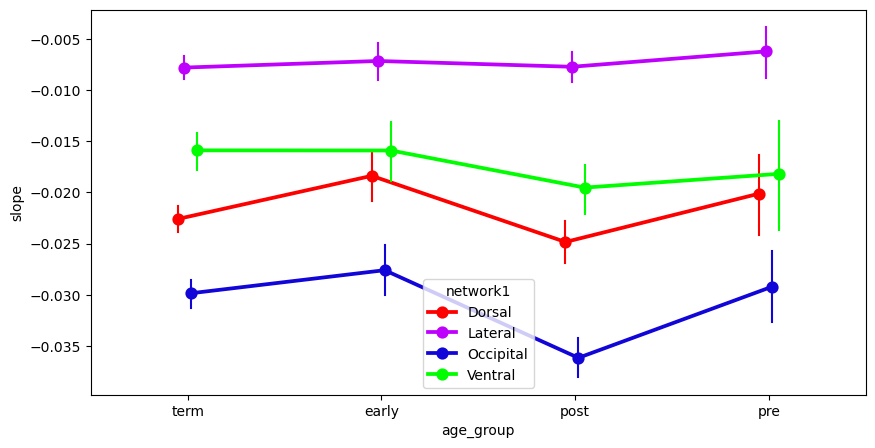

In [51]:
#plot slope as a function of age_group and network
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='slope', data=df_network_summary, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

In [48]:
curr_sub = df_network_summary[df_network_summary['sub'] == sub]
curr_sub = curr_sub[curr_sub['ses'] == ses]
curr_df = curr_sub[curr_sub['network1'] == network]

<Axes: xlabel='roi_dist', ylabel='fc'>

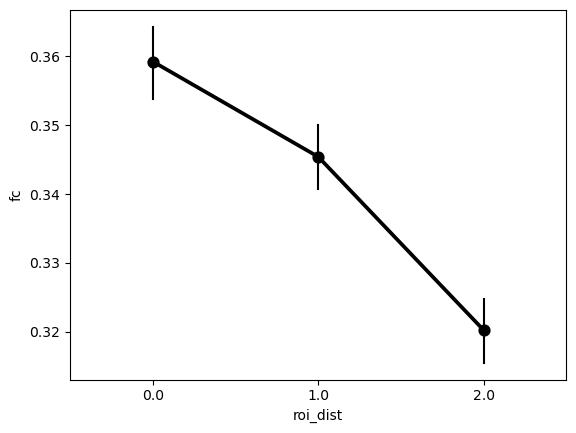

In [31]:
#plot arealization by roi_dist as point plot
plt.figure()
sns.pointplot(x='roi_dist', y='fc', data=df_network_summary, ci=95, markers='o', linestyles='-', errwidth=1.5, capsize=0, color='k')

In [3]:
#load infant data
sub_df = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_{atlas}_roi_similarity.csv')



#add age and age group columns
sub_df['age'] = (sub_df['scan_age'] - sub_df['birth_age'])*7
sub_df['age_group'] = np.nan
for i in range(len(age_bins)-1):
    sub_df.loc[(sub_df['scan_age'] >= age_bins[i]) & (sub_df['scan_age'] < age_bins[i+1]), 'age_group'] = age_groups[i]




# group by hemi_simlarity, roi_similarity, network_similarity
age_df = sub_df.groupby(['sub', 'ses', 'age','age_group','hemi_similarity','roi_similarity','network_similarity', 'network1']).mean(numeric_only=True).reset_index()
#round all values to 4 decimal places
age_df = sub_df.round(4)


#extract only diff hemi_similarity
age_df = age_df[age_df['hemi_similarity'] == 'diff']
#extract only in same network similarity
age_df = age_df[age_df['network_similarity'] == 'same']

#pivot so that sub and network are indices and roi_similarity is columns
age_df = age_df.pivot_table(index = ['sub','ses','age_group','scan_age','birth_age','age','network1'], columns = 'roi_similarity', values = 'fc').reset_index()

#Create new column that is the difference between same and diff
age_df['arealization_index'] = age_df['same'] - age_df['diff']

#save 
age_df.to_csv(f'{git_dir}/results/infant_{atlas}_arealization_index.csv', index = False)

(-0.1, 0.25)

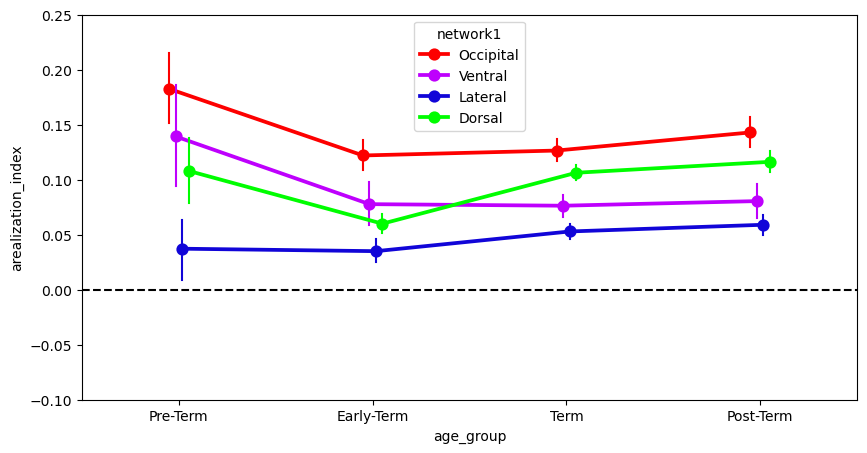

In [14]:
#make age_group categorical
age_df['age_group'] = pd.Categorical(age_df['age_group'], categories=age_groups, ordered=True)
#network categorical
age_df['network1'] = pd.Categorical(age_df['network1'], categories=networks, ordered=True)

#point plot of arealization index
plt.figure(figsize=(10,5))
sns.pointplot(x='age_group', y='arealization_index', data=age_df, hue='network1', palette=network_colors, ci=95, dodge=True, markers='o', linestyles='-', errwidth=1.5, capsize=0)

#dotted line at 0
plt.axhline(y=0, color = 'k', linestyle = '--')

plt.ylim(-.1,.25)

### Grouping